## Read Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.max_columns', 500)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb

In [3]:
df=pd.read_csv("data.csv",encoding='latin1')
df.head()

C:\Users\ranra\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.997490,23.762728,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN

In [4]:
df.shape

(181691, 135)

## Data Cleaning

### Focussing on India and its neighbouring countries

In [5]:
df['region_txt'].value_counts()

Middle East & North Africa     50474
South Asia                     44974
South America                  18978
Sub-Saharan Africa             17550
Western Europe                 16639
Southeast Asia                 12485
Central America & Caribbean    10344
Eastern Europe                  5144
North America                   3456
East Asia                        802
Central Asia                     563
Australasia & Oceania            282
Name: region_txt, dtype: int64

In [6]:
df=df[df['region_txt']=='South Asia']

In [7]:
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
585,197011010001,1970,11,1,NaN,0,NaN,153,Pakistan,6,South Asia,Sindh,Karachi,24.891115,67.143311,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Polish Ministry of Foreign Affairs,Deputy Foreign Minister: Zygfryd Wolniak,161.0,Poland,7.0,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Polish Ministry of Foreign Affairs,Ambassador to Pakistan: Alojzy Bartoszek,161.0,Poland,7.0,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Polish Ministry of Foreign Affairs,Consul General in Karachi: W. Duda,161.0,Poland,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,Vehicle (not to include vehicle-borne explosiv...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Run down by car,4.0,0.0,0.0,20.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
1186,197202220004,1972,2,22,NaN,0,NaN,92,India,6,South Asia,Delhi,New Delhi,28.585836,77.153336,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,4,Hijacking,NaN,NaN,NaN,NaN,6,Airports & Aircraft,42.0,Aircraft (not at an airport),Lufthansa,B-747,75.0,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palestinians,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosives,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,1.0,187.0,0.0,NaN,NaN,Yemen,Yemen,1.0,5000000.0,NaN,NaN,NaN,NaN,2.0,Hostage(s) released by perpetrators,187.0,NaN,NaN,NaN,NaN,Hijacking DB,1,1,1,1,NaN
1863,197305010002,1973,5,1,NaN,0,NaN,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,0,0,9,Unknown,NaN,NaN,NaN,NaN,6,Airports & Aircraft,43.0,Airline Officer/Personnel,Indian Airlines,"unk, asst. mgr., Indian Airlines, Kabul",92.0,India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Black December,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2217,197402020001,1974,2,2,NaN,1,03-02-1974,153,Pakistan,6,South Asia,Sindh,Karachi,24.891115,67.143311,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,11,

In [8]:
df['country_txt'].value_counts()

Pakistan       14368
Afghanistan    12731
India          11960
Sri Lanka       3022
Bangladesh      1648
Nepal           1215
Maldives          22
Bhutan             6
Mauritius          2
Name: country_txt, dtype: int64

In [9]:
l3=['Maldives','Bhutan','Mauritius','Afghanistan']
for i in range(len(l3)):
    df = df.drop(df[df.country_txt == l3[i]].index)

In [10]:
df['country_txt'].value_counts()

Pakistan      14368
India         11960
Sri Lanka      3022
Bangladesh     1648
Nepal          1215
Name: country_txt, dtype: int64

### Handling Missing Values

In [11]:
missing=df.isnull().sum()*100/len(df)
missing

eventid                0.000000
iyear                  0.000000
imonth                 0.000000
iday                   0.000000
approxdate            98.081520
extended               0.000000
resolution            98.832769
country                0.000000
country_txt            0.000000
region                 0.000000
region_txt             0.000000
provstate              0.000000
city                   0.034148
latitude               1.244839
longitude              1.244839
specificity            0.009313
vicinity               0.000000
location              57.622699
summary               22.484711
crit1                  0.000000
crit2                  0.000000
crit3                  0.000000
doubtterr              0.000000
alternative           87.961382
alternative_txt       87.961382
multiple               0.000000
success                0.000000
suicide                0.000000
attacktype1            0.000000
attacktype1_txt        0.000000
                        ...    
propexte

In [12]:
missing50=missing[missing>50]

In [13]:
missing50

approxdate            98.081520
resolution            98.832769
location              57.622699
alternative           87.961382
alternative_txt       87.961382
attacktype2           95.492503
attacktype2_txt       95.492503
attacktype3           99.733027
attacktype3_txt       99.733027
targtype2             94.440133
targtype2_txt         94.440133
targsubtype2          94.666749
targsubtype2_txt      94.666749
corp2                 95.231739
target2               94.505324
natlty2               94.610871
natlty2_txt           94.610871
targtype3             99.518828
targtype3_txt         99.518828
targsubtype3          99.528141
targsubtype3_txt      99.528141
corp3                 99.599541
target3               99.509515
natlty3               99.521932
natlty3_txt           99.521932
gsubname              95.290721
gname2                98.391954
gsubname2             99.888244
gname3                99.705088
gsubname3             99.987583
                        ...    
weaptype

In [14]:
missing50.index[0]

'approxdate'

In [15]:
l1=[missing50.index[i] for i in range(len(missing50))]

In [16]:
type(l1)

list

In [17]:
df1=df.drop(labels=l1,axis=1)
df1.shape

(32213, 59)

In [18]:
df2=df1
df2.head()

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,summary,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,gname,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,ishostkid,scite1,scite2,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
585,197011010001,1970,11,1,0,153,Pakistan,6,South Asia,Sindh,Karachi,24.891115,67.143311,1.0,0,NaN,1,1,1,0.0,0.0,1,0,1,Assassination,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Polish Ministry of Foreign Affairs,Deputy Foreign Minister: Zygfryd Wolniak,161.0,Poland,Unknown,0.0,0,1.0,NaN,NaN,10,Vehicle (not to include vehicle-borne explosiv...,NaN,NaN,Run down by car,4.0,0.0,0.0,20.0,0.0,0.0,0,0.0,NaN,NaN,PGIS,-9,-9,1,1
1186,197202220004,1972,2,22,0,92,India,6,South Asia,Delhi,New Delhi,28.585836,77.153336,1.0,0,NaN,1,1,1,0.0,0.0,1,0,4,Hijacking,6,Airports & Aircraft,42.0,Aircraft (not at an airport),Lufthansa,B-747,75.0,Germany,Palestinians,0.0,0,5.0,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,Explosives,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,NaN,Hijacking DB,1,1,1,1
2217,197402020001,1974,2,2,1,153,Pakistan,6,South Asia,Sindh,Karachi,24.891115,67.143311,1.0,0,NaN,1,1,1,0.0,0.0,1,0,3,Bombing/Explosion,11,Maritime,58.0,Commercial Maritime,NaN,Greek Freighter in Karachi,78.0,Greece,Muslim Guerrillas,0.0,0,3.0,NaN,NaN,5,Firearms,2.0,Automatic or Semi-Automatic Rifle,Automatic firearms; Explosive,0.0,NaN,NaN,0.0,NaN,NaN,0,1.0,NaN,NaN,PGIS,-9,-9,1,1
2705,197412090001,1974,12,9,0,153,Pakistan,6,South Asia,North-West Frontier Province,Peshawar,34.006004,71.537430,1.0,0,NaN,1,1,1,0.0,0.0,1,0,3,Bombing/Explosion,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,USIS Center,217.0,United States,Unknown,0.0,0,NaN,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,Explosive,0.0,0.0,NaN,2.0,2.0,NaN,1,0.0,NaN,NaN,PGIS,-9,-9,1,1
2744,197500000001,1975,0,0,0,153,Pakistan,6,South Asia,Punjab,Rawalpindi,33.594013,73.069077,1.0,0,NaN,1,1,1,0.0,0.0,1,0,3,Bombing/Explosion,6,Airports & Aircraft,42.0,Aircraft (not at an airport),NaN,Pakistan Airlines Boeing 707,153.0,Pakistan,Unknown,0.0,0,NaN,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,NaN,NaN,PGIS,-9,-9,0,-9


In [19]:
z=df2['provstate'].value_counts()
z[:30]

Balochistan                            3710
Sindh                                  3206
Khyber Pakhtunkhwa                     3084
Jammu and Kashmir                      2454
Federally Administered Tribal Areas    2392
Punjab                                 1778
Eastern                                1169
Assam                                  1151
Manipur                                1100
Chhattisgarh                            979
Jharkhand                               887
North-West Frontier Province            866
Northern                                768
Bihar                                   688
Dhaka                                   685
West Bengal                             650
Western                                 595
Central                                 569
Odisha                                  428
Unknown                                 398
Chittagong                              387
Maharashtra                             302
Meghalaya                       

In [20]:
l4=[];
for i in set(df2['provstate']):
    if z[i]<100:
        #print(i)
        l4.append(i)
len(l4)

36

In [21]:
for i in range(len(l4)):
    df2 = df2.drop(df2[df2.provstate == l4[i]].index)
df2['provstate'].value_counts()

Balochistan                            3710
Sindh                                  3206
Khyber Pakhtunkhwa                     3084
Jammu and Kashmir                      2454
Federally Administered Tribal Areas    2392
Punjab                                 1778
Eastern                                1169
Assam                                  1151
Manipur                                1100
Chhattisgarh                            979
Jharkhand                               887
North-West Frontier Province            866
Northern                                768
Bihar                                   688
Dhaka                                   685
West Bengal                             650
Western                                 595
Central                                 569
Odisha                                  428
Unknown                                 398
Chittagong                              387
Maharashtra                             302
Meghalaya                       

In [22]:
df2['targtype1_txt'].value_counts()

Private Citizens & Property       7531
Police                            4759
Government (General)              3581
Military                          3365
Business                          2544
Transportation                    1845
Unknown                           1544
Educational Institution           1414
Violent Political Party            943
Religious Figures/Institutions     848
Utilities                          752
Terrorists/Non-State Militia       571
Journalists & Media                338
Telecommunication                  230
Government (Diplomatic)            149
NGO                                135
Airports & Aircraft                104
Food or Water Supply                48
Maritime                            46
Tourists                            43
Other                                9
Name: targtype1_txt, dtype: int64

In [23]:
miss=df2.isnull().sum()*100/len(df2)
miss

eventid              0.000000
iyear                0.000000
imonth               0.000000
iday                 0.000000
extended             0.000000
country              0.000000
country_txt          0.000000
region               0.000000
region_txt           0.000000
provstate            0.000000
city                 0.035715
latitude             1.301990
longitude            1.301990
specificity          0.009741
vicinity             0.000000
summary             21.922790
crit1                0.000000
crit2                0.000000
crit3                0.000000
doubtterr            0.000000
multiple             0.000000
success              0.000000
suicide              0.000000
attacktype1          0.000000
attacktype1_txt      0.000000
targtype1            0.000000
targtype1_txt        0.000000
targsubtype1         7.052177
targsubtype1_txt     7.052177
corp1               16.471314
target1              0.298711
natlty1              0.357154
natlty1_txt          0.357154
gname     

In [24]:
df2.shape

(30799, 59)

In [25]:
df2.dropna(subset=['corp1', 'targsubtype1','latitude','longitude'],inplace=True)
df2.shape

(23680, 59)

In [26]:
df2['weapsubtype1_txt'] = df2['weapsubtype1_txt'].fillna('Unknown Gun Type')

In [27]:
df2['ishostkid'] = df2['ishostkid'].fillna(0)

In [28]:
df2['natlty1_txt'] = df2['natlty1_txt'].fillna('Others')

In [29]:
df2.dropna(subset=['guncertain1'],inplace=True)
df2.shape

(23679, 59)

In [30]:
df2['claimed'].value_counts()

 0.0    15708
 1.0     3271
-9.0      272
Name: claimed, dtype: int64

In [31]:
df2['claimed'] = df2['claimed'].fillna(0)

In [32]:
df2['nkill'].describe()

count    23228.000000
mean         1.923713
std          7.294295
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        518.000000
Name: nkill, dtype: float64

In [33]:
df2['nkill'] = df2['nkill'].fillna(0)

In [34]:
df2['nwound'].describe()

count    22751.000000
mean         3.113138
std         15.642372
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max       1272.000000
Name: nwound, dtype: float64

In [35]:
df2['nwound'] = df2['nwound'].fillna(0)
df2['nwoundte'] = df2['nwoundte'].fillna(0)
df2['nkillter'] = df2['nkillter'].fillna(0)

In [36]:
df2['nperps'].describe()

count    17319.000000
mean       -67.579248
std        251.053074
min        -99.000000
25%        -99.000000
50%        -99.000000
75%        -99.000000
max      25000.000000
Name: nperps, dtype: float64

In [37]:
def make_others(s):
    if s == -99.0:
        return -1
    else:
        return s
df2['nperps'] = df2['nperps'].apply(make_others)

In [38]:
df2['nperps'] = df2['nperps'].fillna(-1)

In [39]:
df2['nperpcap'].describe()

count    18708.000000
mean        -0.528865
std          8.823318
min        -99.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        406.000000
Name: nperpcap, dtype: float64

In [40]:
def make_others(s):
    if s == -99.0:
        return -1
    else:
        return s
df2['nperpcap'] = df2['nperpcap'].apply(make_others)

In [41]:
df2['nperpcap'] = df2['nperpcap'].fillna(0)

In [42]:
df2.isnull().sum()*100/len(df2)

eventid              0.000000
iyear                0.000000
imonth               0.000000
iday                 0.000000
extended             0.000000
country              0.000000
country_txt          0.000000
region               0.000000
region_txt           0.000000
provstate            0.000000
city                 0.008446
latitude             0.000000
longitude            0.000000
specificity          0.000000
vicinity             0.000000
summary             18.700114
crit1                0.000000
crit2                0.000000
crit3                0.000000
doubtterr            0.000000
multiple             0.000000
success              0.000000
suicide              0.000000
attacktype1          0.000000
attacktype1_txt      0.000000
targtype1            0.000000
targtype1_txt        0.000000
targsubtype1         0.000000
targsubtype1_txt     0.000000
corp1                0.000000
target1              0.181596
natlty1              0.282951
natlty1_txt          0.000000
gname     

### Feature Engineering

#### Threat Level Of a Group : no. of incidents, no. people killed and wounded, propety damage, no. of perpetrator killed or wounded

In [43]:
df2.gname.value_counts()

Unknown                                                         12581
Maoists                                                          1400
Liberation Tigers of Tamil Eelam (LTTE)                          1227
Communist Party of India - Maoist (CPI-Maoist)                   1158
Tehrik-i-Taliban Pakistan (TTP)                                   965
Sikh Extremists                                                   325
People's Liberation Front (JVP)                                   281
Baloch Republican Army (BRA)                                      269
United Liberation Front of Assam (ULFA)                           267
Hizbul Mujahideen (HM)                                            186
Baloch Liberation Front (BLF)                                     180
Muttahida Qami Movement (MQM)                                     169
Lashkar-e-Taiba (LeT)                                             168
Baloch Liberation Army (BLA)                                      161
Garo National Libera

In [44]:
grouped=df2.groupby('gname')

In [45]:
df3=grouped.agg({'eventid':{'No. of incidents':'count'},
             'nkill': 'sum',
             'nwound': 'sum',
             'nkillter': 'sum',
             'nwoundte': 'sum',
             'property': 'count',
             'ishostkid': 'count',
             'iyear': {
                 'recency':lambda x: max(x)-1970,
                 'frequency': lambda x: max(x)-min(x)
             }
            })
df3.head(10)

C:\Users\ranra\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


eventid nkill nwound  \
                                            No. of incidents   sum    sum   
gname                                                                       
A'chik Matgrik Elite Force (AMEF)                          6   0.0    2.0   
Abdullah Azzam Brigades                                    7   9.0   10.0   
Abu Nidal Organization (ANO)                               1  20.0  150.0   
Achik Matgrik Army (AMA)                                   1   0.0    9.0   
Achik National Cooperative Army (ANCA)                     4   2.0    7.0   
Achik National Liberation Army (ANLA)                      4   1.0    0.0   
Achik National Volunteer Council (ANVC)                    1   5.0    2.0   
Achik National Volunteer Council-B (ANVC-B)                8   4.0    3.0   
Achik Songna An'pachakgipa Kotok (ASAK)                   17   1.0    2.0   
Achik Tiger Force                                          1   0.0    0.0   

                                            nkillter nwoundte property  \
                                                 sum      sum    count   
gname                                                                    
A'chik Matgrik Elite Force (AMEF)                0.0      0.0        6   
Abdullah Azzam Brigades                          3.0      0.0        7   
Abu Nidal Organization (ANO)                     0.0      0.0        1   
Achik Matgrik Army (AMA)                         0.0      0.0        1   
Achik National Cooperative Army (ANCA)           0.0      0.0        4   
Achik National Liberation Army (ANLA)            0.0      0.0        4   
Achik National Volunteer Council (ANVC)          0.0      0.0        1   
Achik National Volunteer Council-B (ANVC-B)      0.0      0.0        8   
Achik Songna An'pachakgipa Kotok (ASAK)          1.0      0.0       17   
Achik Tiger Force                                0.0      0.0        1   

                                            ishostkid   iyear            
                                                count recency frequency  
gname                                                                    
A'chik Matgrik Elite Force (AMEF)                   6      46         1  
Abdullah Azzam Brigades                             7      44         3  
Abu Nidal Organization (ANO)                        1      16         0  
Achik Matgrik Army (AMA)                            1      46         0  
Achik National Cooperative Army (ANCA)              4      45         1  
Achik National Liberation Army (ANLA)               4      46         2  
Achik National Volunteer Council (ANVC)             1      31         0  
Achik National Volunteer Council-B (ANVC-B)         8      45         2  
Achik Songna An'pachakgipa Kotok (ASAK)            17      47         3  
Achik Tiger Force                                   1      44         0

In [46]:
df3.sort_values(("eventid",'No. of incidents'),ascending=False, inplace=True)
df3.head()

eventid    nkill  \
                                               No. of incidents      sum   
gname                                                                      
Unknown                                                   12581  13566.0   
Maoists                                                    1400   1263.0   
Liberation Tigers of Tamil Eelam (LTTE)                    1227   8439.0   
Communist Party of India - Maoist (CPI-Maoist)             1158   1755.0   
Tehrik-i-Taliban Pakistan (TTP)                             965   4419.0   

                                                 nwound nkillter nwoundte  \
                                                    sum      sum      sum   
gname                                                                       
Unknown                                         26543.0   1371.0    208.0   
Maoists                                          1309.0    154.0     11.0   
Liberation Tigers of Tamil Eelam (LTTE)          8908.0    868.0     65.0   
Communist Party of India - Maoist (CPI-Maoist)   1321.0    216.0    101.0   
Tehrik-i-Taliban Pakistan (TTP)                  7144.0    985.0    134.0   

                                               property ishostkid   iyear  \
                                                  count     count recency   
gname                                                                       
Unknown                                           12581     12581      47   
Maoists                                            1400      1400      47   
Liberation Tigers of Tamil Eelam (LTTE)            1227      1227      39   
Communist Party of India - Maoist (CPI-Maoist)     1158      1158      47   
Tehrik-i-Taliban Pakistan (TTP)                     965       965      47   

                                                          
                                               frequency  
gname                                                     
Unknown                                               47  
Maoists                                               38  
Liberation Tigers of Tamil Eelam (LTTE)               34  
Communist Party of India - Maoist (CPI-Maoist)        12  
Tehrik-i-Taliban Pakistan (TTP)                       10

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


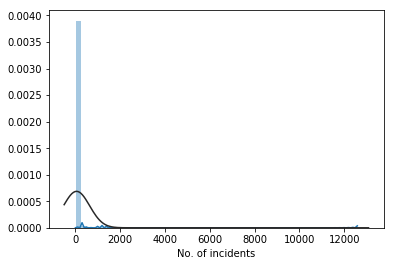

<Figure size 432x288 with 0 Axes>

In [47]:
sns.distplot(df3['eventid']['No. of incidents'], fit=norm);
fig = plt.figure()

In [48]:
df3['totalcount'] = np.log1p(df3['eventid']['No. of incidents'])

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


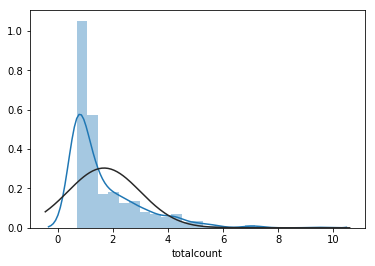

<Figure size 432x288 with 0 Axes>

In [49]:
sns.distplot(df3['totalcount'], fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


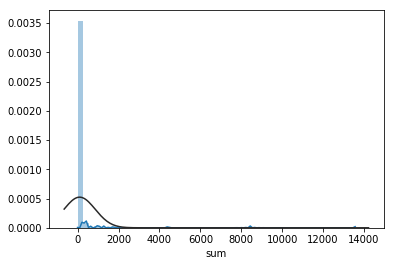

<Figure size 432x288 with 0 Axes>

In [50]:
sns.distplot(df3['nkill']['sum'], fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


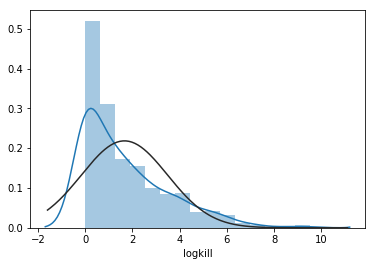

<Figure size 432x288 with 0 Axes>

In [51]:
df3['logkill'] = np.log1p(df3['nkill']['sum'])
sns.distplot(df3['logkill'], fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


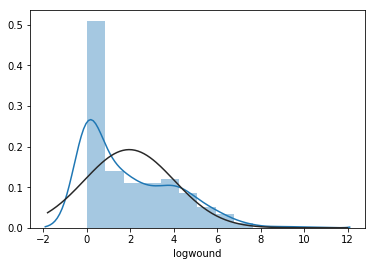

<Figure size 432x288 with 0 Axes>

In [52]:
df3['logwound'] = np.log1p(df3['nwound']['sum'])
sns.distplot(df3['logwound'], fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


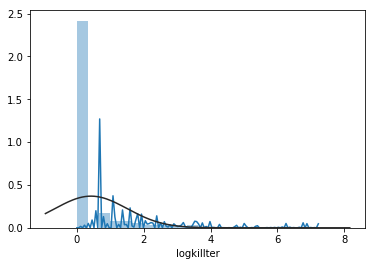

<Figure size 432x288 with 0 Axes>

In [53]:
df3['logkillter'] = np.log1p(df3['nkillter']['sum'])
sns.distplot(df3['logkillter'], fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


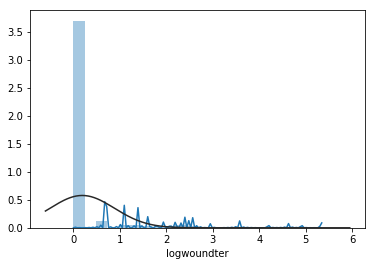

<Figure size 432x288 with 0 Axes>

In [54]:
df3['logwoundter'] = np.log1p(df3['nwoundte']['sum'])
sns.distplot(df3['logwoundter'], fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


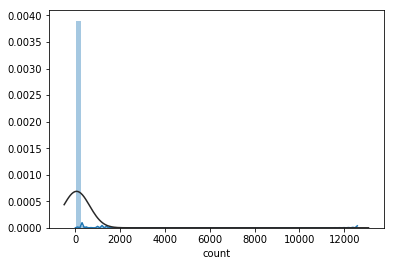

<Figure size 432x288 with 0 Axes>

In [55]:
sns.distplot(df3['property']['count'],fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


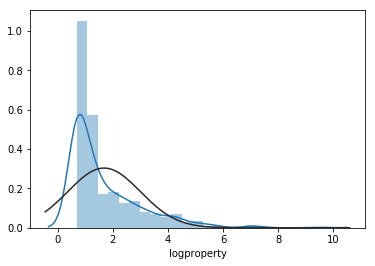

<Figure size 432x288 with 0 Axes>

In [56]:
df3['logproperty'] = np.log1p(df3['property']['count'])
sns.distplot(df3['logproperty'], fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


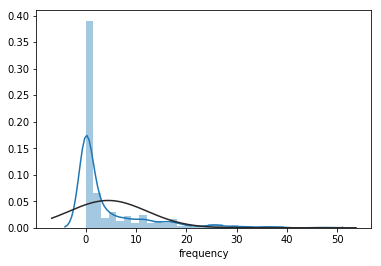

<Figure size 432x288 with 0 Axes>

In [57]:
sns.distplot(df3['iyear']['frequency'],fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


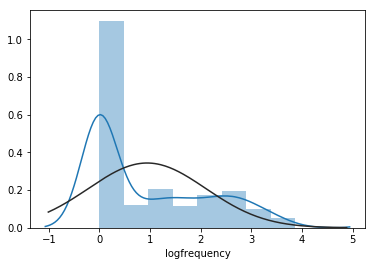

<Figure size 432x288 with 0 Axes>

In [58]:
df3['logfrequency'] = np.log1p(df3['iyear']['frequency'])
sns.distplot(df3['logfrequency'], fit=norm);
fig = plt.figure()

C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


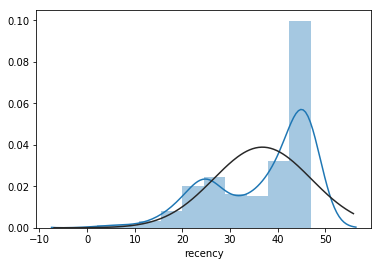

<Figure size 432x288 with 0 Axes>

In [59]:
df3['recency'] = (df3['iyear']['recency'])
sns.distplot(df3['recency'], fit=norm);
fig = plt.figure()

In [60]:
df3.head(3)

eventid    nkill   nwound  \
                                        No. of incidents      sum      sum   
gname                                                                        
Unknown                                            12581  13566.0  26543.0   
Maoists                                             1400   1263.0   1309.0   
Liberation Tigers of Tamil Eelam (LTTE)             1227   8439.0   8908.0   

                                        nkillter nwoundte property ishostkid  \
                                             sum      sum    count     count   
gname                                                                          
Unknown                                   1371.0    208.0    12581     12581   
Maoists                                    154.0     11.0     1400      1400   
Liberation Tigers of Tamil Eelam (LTTE)    868.0     65.0     1227      1227   

                                          iyear           totalcount  \
                                        recency frequency              
gname                                                                  
Unknown                                      47        47   9.440023   
Maoists                                      47        38   7.244942   
Liberation Tigers of Tamil Eelam (LTTE)      39        34   7.113142   

                                          logkill   logwound logkillter  \
                                                                          
gname                                                                     
Unknown                                  9.515396  10.186559   7.224025   
Maoists                                  7.142037   7.177782   5.043425   
Liberation Tigers of Tamil Eelam (LTTE)  9.040738   9.094817   6.767343   

                                        logwoundter logproperty logfrequency  \
                                                                               
gname                                                                          
Unknown                                    5.342334    9.440023     3.871201   
Maoists                                    2.484907    7.244942     3.663562   
Liberation Tigers of Tamil Eelam (LTTE)    4.189655    7.113142     3.555348   

                                        recency  
                                                 
gname                                            
Unknown                                      47  
Maoists                                      47  
Liberation Tigers of Tamil Eelam (LTTE)      39

In [61]:
df3.drop([('eventid','No. of incidents'),('nkill','sum'),('nkillter','sum'),('nwound','sum'),('nwoundte','sum'),('property','count'),('ishostkid','count'),('iyear','recency'),('iyear','frequency')],axis=1,inplace=True)
df3.head()

,totalcount,logkill,logwound,logkillter,logwoundter,logproperty,logfrequency,recency
,,,,,,,,
gname,,,,,,,,
Unknown,9.440023,9.515396,10.186559,7.224025,5.342334,9.440023,3.871201,47
Maoists,7.244942,7.142037,7.177782,5.043425,2.484907,7.244942,3.663562,47
Liberation Tigers of Tamil Eelam (LTTE),7.113142,9.040738,9.094817,6.767343,4.189655,7.113142,3.555348,39
Communist Party of India - Maoist (CPI-Maoist),7.055313,7.470794,7.186901,5.379897,4.624973,7.055313,2.564949,47
Tehrik-i-Taliban Pakistan (TTP),6.873164,8.393895,8.874168,6.893656,4.905275,6.873164,2.397895,47


In [62]:
df3['threat']=df3['totalcount']+df3['logkill']*2+df3['logwound']*2+df3['logproperty']*0.5+df3['logfrequency']*0.5+df3['recency']*0.1
df3.head(3)

,totalcount,logkill,logwound,logkillter,logwoundter,logproperty,logfrequency,recency,threat
,,,,,,,,,
gname,,,,,,,,,
Unknown,9.440023,9.515396,10.186559,7.224025,5.342334,9.440023,3.871201,47,60.199544
Maoists,7.244942,7.142037,7.177782,5.043425,2.484907,7.244942,3.663562,47,46.038831
Liberation Tigers of Tamil Eelam (LTTE),7.113142,9.040738,9.094817,6.767343,4.189655,7.113142,3.555348,39,52.618497


In [63]:
df99=df3[['threat']]
df4=set(df2['gname'])
df4 = pd.DataFrame({'gname':list(df4)})
df4=pd.merge(df4,df99,left_on='gname',right_index=True)
df4.head()

C:\Users\ranra\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,gname,"(threat, )"
0,Local landlord employee,6.312309
1,United Achik National Front (UANF),5.739721
2,Jatav Caste,6.858597
3,U/l men,3.539721
4,Hindu Morcha Nepal,9.111381


In [64]:
df4['Threat']=df4[('threat', '')]
df4.drop([('threat', '')],axis=1,inplace=True)
df4.head()

,gname,Threat
0,Local landlord employee,6.312309
1,United Achik National Front (UANF),5.739721
2,Jatav Caste,6.858597
3,U/l men,3.539721
4,Hindu Morcha Nepal,9.111381


C:\Users\ranra\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


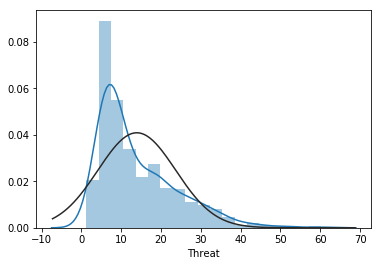

<Figure size 432x288 with 0 Axes>

In [65]:
sns.distplot(df4['Threat'], fit=norm);
fig = plt.figure()

In [66]:
df2=pd.merge(df2,df4,on='gname',how='left')

In [67]:
df2.shape

(23679, 60)

In [68]:
df2.head(3)

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,summary,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,gname,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,ishostkid,scite1,scite2,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,Threat
0,197011010001,1970,11,1,0,153,Pakistan,6,South Asia,Sindh,Karachi,24.891115,67.143311,1.0,0,NaN,1,1,1,0.0,0.0,1,0,1,Assassination,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Polish Ministry of Foreign Affairs,Deputy Foreign Minister: Zygfryd Wolniak,161.0,Poland,Unknown,0.0,0,1.0,0.0,0.0,10,Vehicle (not to include vehicle-borne explosiv...,NaN,Unknown Gun Type,Run down by car,4.0,0.0,0.0,20.0,0.0,0.0,0,0.0,NaN,NaN,PGIS,-9,-9,1,1,60.199544
1,197202220004,1972,2,22,0,92,India,6,South Asia,Delhi,New Delhi,28.585836,77.153336,1.0,0,NaN,1,1,1,0.0,0.0,1,0,4,Hijacking,6,Airports & Aircraft,42.0,Aircraft (not at an airport),Lufthansa,B-747,75.0,Germany,Palestinians,0.0,0,5.0,0.0,0.0,6,Explosives,16.0,Unknown Explosive Type,Explosives,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,NaN,Hijacking DB,1,1,1,1,1.239721
2,197501190004,1975,1,2,0,92,India,6,South Asia,Bihar,Samastipur,25.863042,85.781004,1.0,0,"1/2/1975: The Indian Railway Minister, Lalit N...",1,1,1,0.0,0.0,1,0,3,Bombing/Explosion,2,Government (General),18.0,"Government Personnel (excluding police, military)",Railway Minister of India and legislator,Lalit Narayan Mishra and a legislator,92.0,India,Ananda Marga,1.0,0,-1.0,0.0,0.0,6,Explosives,16.0,Unknown Explosive Type,No additional information available.,4.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"""Leaders of India Irate at Killing: Death of A...","Dhananjay Mahapatra, ""SC: Why has LN Mishra mu...",UMD Encyclopedia of World Terrorism 2012,0,0,0,0,4.758597


In [69]:
df2.drop(['region', 'region_txt'], axis=1, inplace=True)

### Categorical variables handle

In [70]:
#Too many categories in the following columns
#df2['targsubtype1_txt'].value_counts() others karo less than 40
#df2['corp1'].value_counts() others karo
#df2['natlty1_txt'].value_counts() <20
#df2['gname'].value_counts() <10, <5

105

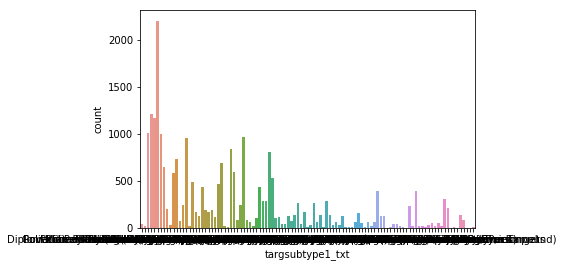

In [71]:
z=df2['targsubtype1_txt'].value_counts()
sns.countplot(x=df2['targsubtype1_txt'])
len(z)

In [72]:
others = []
for i,v in z.items():
    if v<40:
        others.append(i)
len(others)

35

In [73]:
for index, row in tqdm(df2.iterrows()):
    if df2.loc[index,'targsubtype1_txt'] in others:
        df2.loc[index,'targsubtype1_txt'] = 'Others'
df2.shape

23679it [00:02, 10112.65it/s]


(23679, 58)

In [74]:
z=df2['corp1'].value_counts()

In [75]:
def make_cat(s):
    s = s.lower()
    if 'police' in s:
        return 'Police'
    elif 'navy' in s or 'army' in s or 'armed' in s or 'military' in s:
        return 'Army'
    elif 'force' in s:
        return 'Force'
    elif 'gov' in s or 'govt' in s or 'government' in s or 'ministry' in s:
        return 'Government'
    elif 'civillian' in s:
        return 'Civillian'
    elif 'enforcement' in s:
        return 'Enforcement'
    elif 'united nation' in s:
        return 'UN'
    elif 'teachers' in s or 'school' in s or 'education' in s or 'university' in s:
        return 'Education'
    elif 'organisation' in s or 'organization' in s or 'org' in s:
        return 'Org'
    elif 'party' in s or 'national' in s or 'parliament' in s:
        return 'National'
    elif 'mosque' in s or 'temple' in s or 'church' in s or 'gurudwara' in s or 'religion' in s:
        return 'Religion'
    elif 'rail' in s or 'air' in s or 'bus' in s or 'road' in s:
        return 'Transport'
    elif 'new' in s:
        return 'Media'
    elif 'hospital' in s or 'medical' in s:
        return 'Health'
    elif 'plant' in s:
        return 'Power'
    elif 'border' in s:
        return 'Border'
    else:
        return 'Others'

In [76]:
df2['org'] = df2['corp1'].apply(make_cat)

In [77]:
df2['org'].value_counts()

Others        11769
Police         3282
Government     2365
Army           1863
National       1526
Force          1035
Transport       833
Education       374
Religion        174
Org             133
Health          104
UN               96
Media            91
Power            15
Border           13
Civillian         6
Name: org, dtype: int64

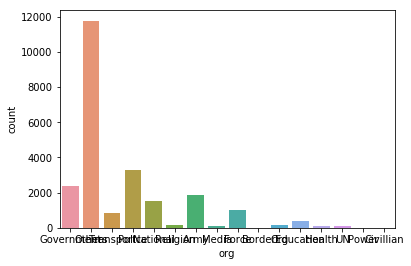

In [78]:
sns.countplot(x=df2['org'])

In [79]:
z=df2['natlty1_txt'].value_counts()
z

Pakistan                10808
India                    8597
Sri Lanka                1852
Bangladesh               1171
Nepal                     718
International             175
Afghanistan                72
Others                     67
United States              49
China                      27
Multinational              17
Iran                       14
Great Britain              12
Saudi Arabia               11
Germany                     7
Japan                       4
Canada                      4
Qatar                       4
Jordan                      4
Russia                      3
Poland                      3
Philippines                 3
Kuwait                      3
United Arab Emirates        3
France                      3
Norway                      2
Indonesia                   2
Sinhalese                   2
Iraq                        2
Thailand                    2
Israel                      2
Iceland                     2
Switzerland                 2
Italy     

In [80]:
others = []
for i,v in z.items():
    if v<10:
        others.append(i)
len(others)

45

In [81]:
for index, row in tqdm(df2.iterrows()):
    if df2.loc[index,'natlty1_txt'] in others:
        df2.loc[index,'natlty1_txt'] = 'Others'

23679it [00:01, 13365.61it/s]


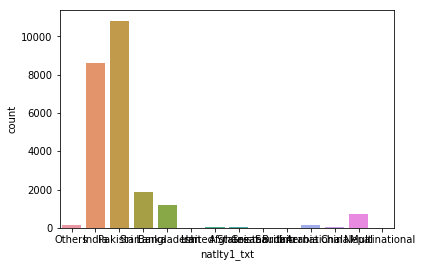

In [82]:
sns.countplot(x=df2['natlty1_txt'])

In [83]:
z=df2['gname'].value_counts()
z

Unknown                                                         12581
Maoists                                                          1400
Liberation Tigers of Tamil Eelam (LTTE)                          1227
Communist Party of India - Maoist (CPI-Maoist)                   1158
Tehrik-i-Taliban Pakistan (TTP)                                   965
Sikh Extremists                                                   325
People's Liberation Front (JVP)                                   281
Baloch Republican Army (BRA)                                      269
United Liberation Front of Assam (ULFA)                           267
Hizbul Mujahideen (HM)                                            186
Baloch Liberation Front (BLF)                                     180
Muttahida Qami Movement (MQM)                                     169
Lashkar-e-Taiba (LeT)                                             168
Baloch Liberation Army (BLA)                                      161
Garo National Libera

In [84]:
others = []
for i,v in z.items():
    if v<10:
        others.append(i)
len(others)

373

In [85]:
def make_others(s):
    if s in others:
        return 'Others'
    else:
        return s
df2['gname'] = df2['gname'].apply(make_others)

In [86]:
df2['gname'].value_counts()

Unknown                                                         12581
Maoists                                                          1400
Liberation Tigers of Tamil Eelam (LTTE)                          1227
Communist Party of India - Maoist (CPI-Maoist)                   1158
Tehrik-i-Taliban Pakistan (TTP)                                   965
Others                                                            886
Sikh Extremists                                                   325
People's Liberation Front (JVP)                                   281
Baloch Republican Army (BRA)                                      269
United Liberation Front of Assam (ULFA)                           267
Hizbul Mujahideen (HM)                                            186
Baloch Liberation Front (BLF)                                     180
Muttahida Qami Movement (MQM)                                     169
Lashkar-e-Taiba (LeT)                                             168
Baloch Liberation Ar

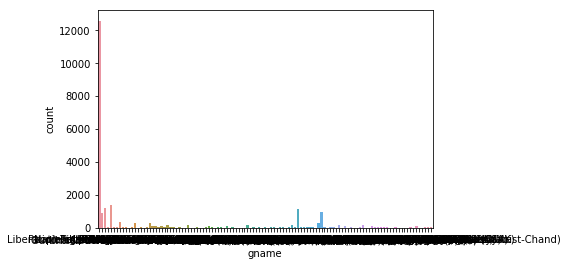

In [87]:
sns.countplot(x=df2['gname'])

In [88]:
df2.head(3)

,eventid,iyear,imonth,iday,extended,country,country_txt,provstate,city,latitude,longitude,specificity,vicinity,summary,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,gname,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,ishostkid,scite1,scite2,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,Threat,org
0,197011010001,1970,11,1,0,153,Pakistan,Sindh,Karachi,24.891115,67.143311,1.0,0,NaN,1,1,1,0.0,0.0,1,0,1,Assassination,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Polish Ministry of Foreign Affairs,Deputy Foreign Minister: Zygfryd Wolniak,161.0,Others,Unknown,0.0,0,1.0,0.0,0.0,10,Vehicle (not to include vehicle-borne explosiv...,NaN,Unknown Gun Type,Run down by car,4.0,0.0,0.0,20.0,0.0,0.0,0,0.0,NaN,NaN,PGIS,-9,-9,1,1,60.199544,Government
1,197202220004,1972,2,22,0,92,India,Delhi,New Delhi,28.585836,77.153336,1.0,0,NaN,1,1,1,0.0,0.0,1,0,4,Hijacking,6,Airports & Aircraft,42.0,Others,Lufthansa,B-747,75.0,Others,Others,0.0,0,5.0,0.0,0.0,6,Explosives,16.0,Unknown Explosive Type,Explosives,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,NaN,Hijacking DB,1,1,1,1,1.239721,Others
2,197501190004,1975,1,2,0,92,India,Bihar,Samastipur,25.863042,85.781004,1.0,0,"1/2/1975: The Indian Railway Minister, Lalit N...",1,1,1,0.0,0.0,1,0,3,Bombing/Explosion,2,Government (General),18.0,"Government Personnel (excluding police, military)",Railway Minister of India and legislator,Lalit Narayan Mishra and a legislator,92.0,India,Others,1.0,0,-1.0,0.0,0.0,6,Explosives,16.0,Unknown Explosive Type,No additional information available.,4.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"""Leaders of India Irate at Killing: Death of A...","Dhananjay Mahapatra, ""SC: Why has LN Mishra mu...",UMD Encyclopedia of World Terrorism 2012,0,0,0,0,4.758597,Transport


In [89]:
# dfa=df2[['eventid','iyear','imonth',
      #'iday','country_txt','provstate','city','latitude','longitude','gname','targtype1_txt','Threat']]

In [90]:
# dfa.to_csv('dash.csv', sep=',')

In [91]:
dropped=['summary','weapdetail','dbsource','scite1','corp1','city','eventid','country','latitude','longitude','nkill','nkillus','nkillter','nwound','nwoundus','nwoundte','target1','attacktype1','targtype1','targsubtype1','natlty1','nperpcap','weaptype1','weapsubtype1']
df2.drop(dropped,axis=1,inplace=True)

In [92]:
df2.drop(['scite2'],axis=1,inplace=True)

In [93]:
df2.head(3)

,iyear,imonth,iday,extended,country_txt,provstate,specificity,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1_txt,targtype1_txt,targsubtype1_txt,natlty1_txt,gname,guncertain1,individual,nperps,claimed,weaptype1_txt,weapsubtype1_txt,property,ishostkid,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,Threat,org
0,1970,11,1,0,Pakistan,Sindh,1.0,0,1,1,1,0.0,0.0,1,0,Assassination,Government (Diplomatic),"Diplomatic Personnel (outside of embassy, cons...",Others,Unknown,0.0,0,1.0,0.0,Vehicle (not to include vehicle-borne explosiv...,Unknown Gun Type,0,0.0,-9,-9,1,1,60.199544,Government
1,1972,2,22,0,India,Delhi,1.0,0,1,1,1,0.0,0.0,1,0,Hijacking,Airports & Aircraft,Others,Others,Others,0.0,0,5.0,0.0,Explosives,Unknown Explosive Type,0,1.0,1,1,1,1,1.239721,Others
2,1975,1,2,0,India,Bihar,1.0,0,1,1,1,0.0,0.0,1,0,Bombing/Explosion,Government (General),"Government Personnel (excluding police, military)",India,Others,1.0,0,-1.0,0.0,Explosives,Unknown Explosive Type,0,0.0,0,0,0,0,4.758597,Transport


In [94]:
df2.shape

(23679, 34)

In [95]:
df2.dtypes

iyear                 int64
imonth                int64
iday                  int64
extended              int64
country_txt          object
provstate            object
specificity         float64
vicinity              int64
crit1                 int64
crit2                 int64
crit3                 int64
doubtterr           float64
multiple            float64
success               int64
suicide               int64
attacktype1_txt      object
targtype1_txt        object
targsubtype1_txt     object
natlty1_txt          object
gname                object
guncertain1         float64
individual            int64
nperps              float64
claimed             float64
weaptype1_txt        object
weapsubtype1_txt     object
property              int64
ishostkid           float64
INT_LOG               int64
INT_IDEO              int64
INT_MISC              int64
INT_ANY               int64
Threat              float64
org                  object
dtype: object

In [96]:
#df2.to_csv('clean_data_35_notencoded.csv', sep=',')

In [97]:
c=['org','targsubtype1_txt','country_txt','provstate','attacktype1_txt','targtype1_txt','natlty1_txt','gname','weaptype1_txt','weapsubtype1_txt']
le=LabelEncoder()
for i in c:
    df2[i] = df2[i].astype('category')
    df2[i] = le.fit_transform(df2[i])

In [98]:
df2.head(3)

,iyear,imonth,iday,extended,country_txt,provstate,specificity,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1_txt,targtype1_txt,targsubtype1_txt,natlty1_txt,gname,guncertain1,individual,nperps,claimed,weaptype1_txt,weapsubtype1_txt,property,ishostkid,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,Threat,org
0,1970,11,1,0,3,28,1.0,0,1,1,1,0.0,0.0,1,0,1,4,8,9,109,0.0,0,1.0,0.0,10,27,0,0.0,-9,-9,1,1,60.199544,5
1,1972,2,22,0,1,7,1.0,0,1,1,1,0.0,0.0,1,0,4,0,41,9,77,0.0,0,5.0,0.0,2,26,0,1.0,1,1,1,1,1.239721,10
2,1975,1,2,0,1,3,1.0,0,1,1,1,0.0,0.0,1,0,2,5,17,4,77,1.0,0,-1.0,0.0,2,26,0,0.0,0,0,0,0,4.758597,14


In [99]:
df2.reset_index(inplace = True)

In [100]:
df2.drop(['index'],axis=1,inplace=True)
df2.head(3)

,iyear,imonth,iday,extended,country_txt,provstate,specificity,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1_txt,targtype1_txt,targsubtype1_txt,natlty1_txt,gname,guncertain1,individual,nperps,claimed,weaptype1_txt,weapsubtype1_txt,property,ishostkid,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,Threat,org
0,1970,11,1,0,3,28,1.0,0,1,1,1,0.0,0.0,1,0,1,4,8,9,109,0.0,0,1.0,0.0,10,27,0,0.0,-9,-9,1,1,60.199544,5
1,1972,2,22,0,1,7,1.0,0,1,1,1,0.0,0.0,1,0,4,0,41,9,77,0.0,0,5.0,0.0,2,26,0,1.0,1,1,1,1,1.239721,10
2,1975,1,2,0,1,3,1.0,0,1,1,1,0.0,0.0,1,0,2,5,17,4,77,1.0,0,-1.0,0.0,2,26,0,0.0,0,0,0,0,4.758597,14


In [101]:
df2.shape

(23679, 34)

In [102]:
# df2.to_csv('clean_data_36.csv', sep=',')

## MODEL

In [103]:
Y=df2.iloc[:, 5].values

In [104]:
len(set(Y))

35

In [105]:
df2.drop(['provstate'],axis=1,inplace=True)

In [106]:
df2.head(3)

,iyear,imonth,iday,extended,country_txt,specificity,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1_txt,targtype1_txt,targsubtype1_txt,natlty1_txt,gname,guncertain1,individual,nperps,claimed,weaptype1_txt,weapsubtype1_txt,property,ishostkid,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,Threat,org
0,1970,11,1,0,3,1.0,0,1,1,1,0.0,0.0,1,0,1,4,8,9,109,0.0,0,1.0,0.0,10,27,0,0.0,-9,-9,1,1,60.199544,5
1,1972,2,22,0,1,1.0,0,1,1,1,0.0,0.0,1,0,4,0,41,9,77,0.0,0,5.0,0.0,2,26,0,1.0,1,1,1,1,1.239721,10
2,1975,1,2,0,1,1.0,0,1,1,1,0.0,0.0,1,0,2,5,17,4,77,1.0,0,-1.0,0.0,2,26,0,0.0,0,0,0,0,4.758597,14


In [107]:
X = df2.values

In [108]:
df2.shape

(23679, 33)

In [112]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [113]:
sc = StandardScaler()

In [114]:
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [115]:
# lg = lgb.LGBMClassifier(silent=False)
# param_dist = {"objective" : "multiclass",
#               'boosting_type': 'gbdt',
#               'num_class':99,
#               "max_depth": [5,20, 40],
#               "learning_rate" : [0.001,0.01,0.1],
#               "num_leaves": [30,600,900],
#               "n_estimators": [200,300],
#               'metric': 'multi_logloss',
#              }

In [116]:
# grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
# grid_search.fit(x_train,y_train)

In [117]:
# grid_search.best_estimator_

In [153]:
d_train = lgb.Dataset(x_train, label=y_train)
params = {"objective" : "multiclass",'boosting_type': 'gbdt','num_class':35,"max_depth": 17,
          "learning_rate" : 0.001,"num_leaves": 2300,'metric': 'multi_logloss'}

In [154]:
cat =[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,32]

In [155]:
model2 = lgb.train(params, d_train,1000, categorical_feature = cat)

C:\Users\ranra\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 32]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [156]:
ypred2=model2.predict(x_test)

In [157]:
ypred1=np.argmax(ypred2,axis=1)

In [158]:
y_test[0:5]

array([ 2,  5, 17, 26, 10], dtype=int64)

In [159]:
ypred1[0:5]

array([ 2,  5, 17, 26, 10], dtype=int64)

In [160]:
accuracy_score(ypred1,y_test)

0.5506756756756757

In [161]:
y_train_p=model2.predict(x_train)

In [162]:
y_train_p=np.argmax(y_train_p,axis=1)

In [163]:
accuracy_score(y_train_p,y_train)

0.7098935750886874